# Deterministic Linear Transport equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial r}{\partial t} + v\frac{\partial j}{\partial x} = \frac{\sigma(x, z)}{\epsilon^2}(\hat{r} - r), \\
&\frac{\partial j}{\partial t} + \frac{v}{\epsilon^2}\frac{\partial r}{\partial x} = - \frac{\sigma(x, z)}{\epsilon^2}j, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number, $v \in [0, 1]$, and $\hat{r} = \int_{0}^{1} rdv$. 

It seems to me that $v$ follows a uniform distribution (as Gauss-Legendre quadrature is used to compute the integral).

We let $\sigma(x, z) \equiv 1$.

The initial data are
$$
\begin{aligned}
&r = \rho_0 \left(\exp\left(-\left(\frac{v-0.75}{T_0}\right)^2\right) + \exp\left(-\left(\frac{v-0.75}{T_0}\right)^2\right)\right), \\
&j = 0, \\
&\rho_0 = 1+0.5\sin(2\pi x), \\
&T_0 = 0.25+0.1\cos(2\pi x).
\end{aligned}
$$

BC: periodic BC, on 
$$
r, j, r_x, j_x
$$

The spatiotemporal domain is 
$$
(x, t, v) \in [0, 1]\times [0, 0.02] \times [0, 1].
$$

In [1]:
NAME = "5_periodic_bc_epsilon_1e-8_delta_t"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [4] + [32]*4 + [2] # (x, t, v) -> (r, j)
c0 = 1.0
w0 = jnp.array([[1.0, 1.0, 1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_r, w_j)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[0., 0., 0.0], [1., 0.02, 1.0]])

sigma = 1.0
epsilon = 1e-8

@jax.jit
def model(params, xtv): # for predictions
	xtv = (2*xtv - (domain[0, :]+domain[1, :]))/(domain[1, :] - domain[0, :])/2
	xtv = jnp.dot(xtv, jnp.array([[1.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]))
	xtv = index_update(xtv, index[:,0], jnp.sin(2*jnp.pi*xtv[:,0]))
	xtv = index_update(xtv, index[:,1], jnp.cos(2*jnp.pi*xtv[:,1]))
	for w, b in params[:-1]:
		xtv = jnp.sin(jnp.dot(xtv, w) + b)
	return jnp.dot(xtv, params[-1][0]) + params[-1][1]

@jax.jit
def model_(params, xtv): # for derivatives
	xtv = (2*xtv - (domain[0, :]+domain[1, :]))/(domain[1, :] - domain[0, :])/2
	xtv = jnp.dot(xtv, jnp.array([[1.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]]))
	xtv = index_update(xtv, index[0], jnp.sin(2*jnp.pi*xtv[0]))
	xtv = index_update(xtv, index[1], jnp.cos(2*jnp.pi*xtv[1]))
	for w, b in params[:-1]:
		xtv = jnp.sin(jnp.dot(xtv, w) + b)
	return jnp.dot(xtv, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model_)
hessian = hessian_fn(model_)

In [4]:
# n_cx = 201
# n_ct = 100
# x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
# t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
# # v_c = jnp.linspace(*domain[:, 2], n_cv).reshape((-1, 1))
# v_c = [1]
# xtv_c = tensor_grid([x_c, t_c, v_c])

# dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t", "v"])
# collocation = dataset_Collocation(xtv_c[:, 0:1], xtv_c[:, 1:2], xtv_c[:, 2:3])

# rj_c = model(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
# r_c, j_c = rj_c[:, 0:1], rj_c[:, 1:2]
# drj_dxtv_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
# dr_dt_c, dj_dt_c = drj_dxtv_c[:, 0:1, 1], drj_dxtv_c[:, 1:2, 1]
# dr_dx_c, dj_dx_c = drj_dxtv_c[:, 0:1, 0], drj_dxtv_c[:, 1:2, 0]

# r_hat_c = quadrature(direct_params, collocation.x, collocation.t, quad.v, quad.w)

# loss_c1 = jnp.abs(epsilon**2*(dr_dt_c + collocation.v*dj_dx_c)-sigma*(r_hat_c - r_c)).reshape((n_cx, n_ct))
# loss_c2 = jnp.abs(epsilon**2*dj_dt_c + collocation.v*dr_dx_c+sigma*j_c).reshape((n_cx, n_ct))

# import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
# %matplotlib notebook

# f = plt.figure()
# ax = plt.axes(projection="3d")
# T, X = np.meshgrid(t_c, x_c)
# ax.plot_surface(X, T, loss_c1, cmap = "cool")
# ax.set_xlabel("x")
# ax.set_ylabel("t")

# f = plt.figure()
# ax = plt.axes(projection="3d")
# ax.plot_surface(X, T, loss_c2, cmap = "cool")
# ax.set_xlabel("x")
# ax.set_ylabel("t")

# plt.show()

NameError: name 'quadrature' is not defined

In [5]:
metaloss = mse

static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def quadrature(params, x, t, v, w):
	xt_ = jnp.repeat(jnp.hstack([x, t]), w.shape[0], axis = 0)
	v_ = jnp.tile(v, (x.shape[0], 1))
	rj = model(params, jnp.hstack([xt_, v_]))
	r = rj[:, 0:1].reshape((x.shape[0], w.shape[0]))
	return jnp.dot(r, w)

# jacobian[i] = [[dr/dx, dr/dt, dr/dv],
#                [dj/dx, dj/dt, dj/dv]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, quad = batch["collocation"], batch["dirichlet"], batch["quad"]
	direct_params = params
	
	if collocation[0] is not None:
		rj_c = model(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		r_c, j_c = rj_c[:, 0:1], rj_c[:, 1:2]
		drj_dxtv_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		dr_dt_c, dj_dt_c = drj_dxtv_c[:, 0:1, 1], drj_dxtv_c[:, 1:2, 1]
		dr_dx_c, dj_dx_c = drj_dxtv_c[:, 0:1, 0], drj_dxtv_c[:, 1:2, 0]
		
		# quad.w: [q, 1]
		# quad.v: [q, 1]
		r_hat_c = quadrature(direct_params, collocation.x, collocation.t, quad.v, quad.w)
		
		loss_c1 = metaloss(epsilon**2*(dr_dt_c + collocation.v*dj_dx_c), sigma*(r_hat_c - r_c))
		loss_c2 = metaloss(epsilon**2*dj_dt_c + collocation.v*dr_dx_c, -sigma*j_c)
	else:
		loss_c1 = loss_c2 = 0
        
	if dirichlet[0] is not None:
		rj_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t, dirichlet.v]))
		r_d, j_d = rj_d[:, 0:1], rj_d[:, 1:2]
		loss_dr = metaloss(r_d, dirichlet.r)
		loss_dj = metaloss(j_d, dirichlet.j)
	else:
		loss_dr = loss_dj = 0.0
		
# 	if bc[0] is not None:
# 		rj_bl = model(direct_params, jnp.hstack([bc.l, bc.t, bc.v]))
# 		rj_br = model(direct_params, jnp.hstack([bc.r, bc.t, bc.v]))
# 		r_bl, j_bl = rj_bl[:, 0:1], rj_bl[:, 1:2]
# 		r_br, j_br = rj_br[:, 0:1], rj_br[:, 1:2]
# 		drj_dxtv_bl = jacobian(direct_params, jnp.hstack([bc.l, bc.t, bc.v]))
# 		drj_dxtv_br = jacobian(direct_params, jnp.hstack([bc.r, bc.t, bc.v]))
# 		dr_dx_bl, dr_dx_br = drj_dxtv_bl[:, 0:1, 0], drj_dxtv_br[:, 0:1, 0]
# 		dj_dx_bl, dj_dx_br = drj_dxtv_bl[:, 1:2, 0], drj_dxtv_br[:, 1:2, 0]
		
# 		loss_b1 = metaloss(r_bl, r_br) + metaloss(j_bl, j_br)
# 		loss_b2 = metaloss(dr_dx_bl, dr_dx_br) + metaloss(dj_dx_bl, dj_dx_br)
		
# 		loss_b1 = metaloss(sigma*j_bl, -bc.v*dr_dx_bl) + metaloss(sigma*j_br, -bc.v*dr_dx_br)
# 		loss_b2 = metaloss(r_bl - epsilon/sigma*bc.v*dr_dx_bl, 1.0) + metaloss(r_br + epsilon/sigma*bc.v*dr_dx_br, 0.0)

	return loss_c1, loss_c2, loss_dr, loss_dj

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_dr, loss_dj = loss_fn_(params, batch)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["dr"]*loss_dr + w["dj"]*loss_dj + \
			l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_dr, loss_dj = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["dr"]*loss_dr + w["dj"]*loss_dj, \
			loss_c1, loss_c2, loss_dr, loss_dj, l1, l2

In [6]:
rho0_fn = lambda x: 1+0.5*jnp.sin(jnp.pi*2*x)
T0_fn = lambda x: 0.25+0.1*jnp.cos(jnp.pi*2*x)
r0_fn = lambda x, t, v: rho0_fn(x)*(jnp.exp(-((v - 0.75)/T0_fn(x))**2) + jnp.exp(-((v+0.75)/T0_fn(x))**2))
j0_fn = lambda x, t, v: jnp.zeros_like(x)

key, *subkeys = random.split(key, 3)

n_quad = 16
v_quad, w_quad = np.polynomial.legendre.leggauss(n_quad)
v_quad = jnp.array(0.5*(v_quad+1), dtype = jnp.float32).reshape((-1, 1))
w_quad = jnp.array(0.5*w_quad, dtype = jnp.float32).reshape((-1, 1))

n_i = 200
x_i = jnp.linspace(*domain[:, 0], n_i)
# v_i = jnp.linspace(*domain[:, 2], n_i)
v_i = v_quad
xv_i = tensor_grid([x_i, v_i])
x_i, v_i = xv_i[:, 0:1], xv_i[:, 1:2]
t_i = jnp.zeros_like(x_i)
r_i = r0_fn(x_i, t_i, v_i)
j_i = j0_fn(x_i, t_i, v_i)

n_cx = 201
n_ct = 100
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(0.0002, domain[1, 1], n_ct).reshape((-1, 1))
# t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
# v_c = jnp.linspace(*domain[:, 2], n_cv).reshape((-1, 1))
v_c = v_quad
xtv_c = tensor_grid([x_c, t_c, v_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "v", "r", "j"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t", "v"])
dataset_Quad = namedtuple("dataset_Quad", ["w", "v"])

dirichlet = dataset_Dirichlet(x_i, t_i, v_i, r_i, j_i)
collocation = dataset_Collocation(xtv_c[:, 0:1], xtv_c[:, 1:2], xtv_c[:, 2:3])
quad = dataset_Quad(w_quad, v_quad)

In [7]:
lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 200, "collocation": 20100}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])

start_iteration = 0
iterations = 20000
print_every = 1000
save_every = 10000
weights = {"c1": 10.0, "c2": 10.0, "dr": 10.0, "dj": 10.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]]), jnp.vstack([d[2], c[2]])),
		"collocation": dataset_Collocation(*c),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "dr", "dj", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/09/01, 11:13:42, Iteration: 0, Train Loss: 2.7401e+00, c1: 2.6941e-04, c2: 5.8792e-03, dr: 2.5936e-01, dj: 8.4994e-03, l1_reg: 3.0670e+02, l2_reg: 4.3333e+01
2020/09/01, 11:13:55, Iteration: 1000, Train Loss: 5.5058e-01, c1: 1.7874e-02, c2: 6.4681e-03, dr: 3.0033e-02, dj: 6.8262e-04, l1_reg: 3.6494e+02, l2_reg: 6.8011e+01
2020/09/01, 11:14:08, Iteration: 2000, Train Loss: 1.8114e-01, c1: 3.6364e-03, c2: 8.3565e-03, dr: 5.9857e-03, dj: 1.3582e-04, l1_reg: 4.0781e+02, l2_reg: 9.1113e+01
2020/09/01, 11:14:22, Iteration: 3000, Train Loss: 8.8623e-02, c1: 1.5805e-03, c2: 5.1593e-03, dr: 2.0566e-03, dj: 6.5822e-05, l1_reg: 4.3721e+02, l2_reg: 1.0782e+02
2020/09/01, 11:14:36, Iteration: 4000, Train Loss: 5.0120e-02, c1: 8.6282e-04, c2: 2.5213e-03, dr: 1.5976e-03, dj: 3.0281e-05, l1_reg: 4.6273e+02, l2_reg: 1.2329e+02
2020/09/01, 11:14:49, Iteration: 5000, Train Loss: 5.8842e-02, c1: 7.2055e-04, c2: 2.0072e-03, dr: 3.1426e-03, dj: 1.3845e-05, l1_reg: 4.7931e+02, l2_reg: 1.3379e+02
2020/09

In [10]:
start_iteration = 20000
iterations = 200000
print_every = 1000
save_every = 10000
weights = {"c1": 10.0, "c2": 10.0, "dr": 10.0, "dj": 10.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
# 		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]]), jnp.vstack([d[2], c[2]])),
		"collocation": dataset_Collocation(*c),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "dr", "dj", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/09/01, 11:20:59, Iteration: 20000, Train Loss: 2.3156e-01, c1: 1.7238e-04, c2: 2.8236e-04, dr: 2.2701e-02, dj: 6.0402e-07, l1_reg: 5.3959e+02, l2_reg: 1.7711e+02
2020/09/01, 11:21:12, Iteration: 21000, Train Loss: 3.2587e-03, c1: 9.2288e-05, c2: 1.7054e-04, dr: 6.2585e-05, dj: 4.5390e-07, l1_reg: 5.4110e+02, l2_reg: 1.7847e+02
2020/09/01, 11:21:25, Iteration: 22000, Train Loss: 2.8415e-03, c1: 7.9221e-05, c2: 1.5585e-04, dr: 4.8611e-05, dj: 4.6787e-07, l1_reg: 5.4251e+02, l2_reg: 1.7990e+02
2020/09/01, 11:21:39, Iteration: 23000, Train Loss: 1.8949e-02, c1: 5.7586e-05, c2: 1.1496e-04, dr: 1.7219e-03, dj: 4.0141e-07, l1_reg: 5.4461e+02, l2_reg: 1.8168e+02
2020/09/01, 11:21:53, Iteration: 24000, Train Loss: 1.2936e-01, c1: 2.4217e-04, c2: 6.1524e-04, dr: 1.2076e-02, dj: 3.2095e-06, l1_reg: 5.4606e+02, l2_reg: 1.8327e+02
2020/09/01, 11:22:06, Iteration: 25000, Train Loss: 2.7938e-03, c1: 9.1113e-05, c2: 1.6468e-04, dr: 2.3107e-05, dj: 4.8193e-07, l1_reg: 5.4710e+02, l2_reg: 1.8433e+0

2020/09/01, 11:32:24, Iteration: 70000, Train Loss: 7.7599e-04, c1: 8.3015e-06, c2: 4.6963e-05, dr: 2.2193e-05, dj: 1.4065e-07, l1_reg: 7.0271e+02, l2_reg: 3.1344e+02
2020/09/01, 11:32:37, Iteration: 71000, Train Loss: 6.6539e-04, c1: 6.2330e-06, c2: 2.8577e-05, dr: 3.1682e-05, dj: 4.7100e-08, l1_reg: 7.0476e+02, l2_reg: 3.1556e+02
2020/09/01, 11:32:51, Iteration: 72000, Train Loss: 9.3614e-04, c1: 5.7902e-06, c2: 3.1961e-05, dr: 5.5527e-05, dj: 3.3598e-07, l1_reg: 7.0711e+02, l2_reg: 3.1787e+02
2020/09/01, 11:33:05, Iteration: 73000, Train Loss: 4.1787e-04, c1: 5.1452e-06, c2: 2.2419e-05, dr: 1.4163e-05, dj: 5.9674e-08, l1_reg: 7.0950e+02, l2_reg: 3.2026e+02
2020/09/01, 11:33:18, Iteration: 74000, Train Loss: 3.8753e-04, c1: 4.2493e-06, c2: 1.6678e-05, dr: 1.7786e-05, dj: 3.9656e-08, l1_reg: 7.1143e+02, l2_reg: 3.2219e+02
2020/09/01, 11:33:32, Iteration: 75000, Train Loss: 7.0223e-03, c1: 1.4498e-04, c2: 4.7342e-04, dr: 8.3001e-05, dj: 8.2633e-07, l1_reg: 7.2634e+02, l2_reg: 3.3545e+0

2020/09/01, 11:43:35, Iteration: 119000, Train Loss: 2.3493e-04, c1: 1.8514e-06, c2: 8.7062e-06, dr: 1.2898e-05, dj: 3.7131e-08, l1_reg: 8.2280e+02, l2_reg: 4.4006e+02
2020/09/01, 11:43:49, Iteration: 120000, Train Loss: 2.8039e-03, c1: 4.5287e-05, c2: 1.5493e-04, dr: 7.9480e-05, dj: 6.9525e-07, l1_reg: 8.2189e+02, l2_reg: 4.4061e+02
2020/09/01, 11:44:02, Iteration: 121000, Train Loss: 8.1008e-04, c1: 1.2139e-05, c2: 4.6085e-05, dr: 2.2742e-05, dj: 4.1066e-08, l1_reg: 8.2446e+02, l2_reg: 4.4353e+02
2020/09/01, 11:44:16, Iteration: 122000, Train Loss: 7.9096e-04, c1: 6.1417e-06, c2: 2.8633e-05, dr: 4.4232e-05, dj: 8.9475e-08, l1_reg: 8.2543e+02, l2_reg: 4.4485e+02
2020/09/01, 11:44:30, Iteration: 123000, Train Loss: 5.6726e-04, c1: 4.2598e-06, c2: 2.1731e-05, dr: 3.0649e-05, dj: 8.6281e-08, l1_reg: 8.2625e+02, l2_reg: 4.4626e+02
2020/09/01, 11:44:44, Iteration: 124000, Train Loss: 1.3744e-03, c1: 3.4731e-06, c2: 3.1296e-05, dr: 1.0263e-04, dj: 3.7013e-08, l1_reg: 8.2689e+02, l2_reg: 4.4

2020/09/01, 11:54:47, Iteration: 168000, Train Loss: 2.9471e-04, c1: 2.4193e-06, c2: 9.6970e-06, dr: 1.7214e-05, dj: 1.4101e-07, l1_reg: 8.6070e+02, l2_reg: 4.7869e+02
2020/09/01, 11:55:00, Iteration: 169000, Train Loss: 2.3111e-04, c1: 1.9250e-06, c2: 7.5960e-06, dr: 1.3567e-05, dj: 2.3356e-08, l1_reg: 8.6071e+02, l2_reg: 4.7890e+02
2020/09/01, 11:55:14, Iteration: 170000, Train Loss: 1.1669e-04, c1: 1.4567e-06, c2: 4.8749e-06, dr: 5.2766e-06, dj: 6.1158e-08, l1_reg: 8.6090e+02, l2_reg: 4.7896e+02
2020/09/01, 11:55:27, Iteration: 171000, Train Loss: 1.0585e-04, c1: 1.0372e-06, c2: 4.3483e-06, dr: 5.0936e-06, dj: 1.0601e-07, l1_reg: 8.6109e+02, l2_reg: 4.7892e+02
2020/09/01, 11:55:40, Iteration: 172000, Train Loss: 8.0363e-05, c1: 9.1243e-07, c2: 3.6231e-06, dr: 3.3623e-06, dj: 1.3853e-07, l1_reg: 8.6133e+02, l2_reg: 4.7893e+02
2020/09/01, 11:55:53, Iteration: 173000, Train Loss: 2.4257e-04, c1: 1.0014e-06, c2: 3.9342e-06, dr: 1.9256e-05, dj: 6.5936e-08, l1_reg: 8.6146e+02, l2_reg: 4.7

2020/09/01, 12:05:20, Iteration: 217000, Train Loss: 1.0213e-04, c1: 5.5458e-07, c2: 3.0861e-06, dr: 6.5446e-06, dj: 2.7288e-08, l1_reg: 9.1214e+02, l2_reg: 5.3458e+02
2020/09/01, 12:05:32, Iteration: 218000, Train Loss: 2.0217e-04, c1: 2.5889e-06, c2: 1.0721e-05, dr: 6.8420e-06, dj: 6.4651e-08, l1_reg: 9.1170e+02, l2_reg: 5.3589e+02
2020/09/01, 12:05:45, Iteration: 219000, Train Loss: 4.1507e-05, c1: 5.2957e-07, c2: 2.2762e-06, dr: 1.3430e-06, dj: 1.9917e-09, l1_reg: 9.1174e+02, l2_reg: 5.3586e+02
2020/09/01, 12:05:58, Iteration: 220000, Train Loss: 4.5614e-05, c1: 4.0283e-07, c2: 1.6921e-06, dr: 2.4598e-06, dj: 6.6826e-09, l1_reg: 9.1173e+02, l2_reg: 5.3575e+02


In [11]:
from scipy.io import loadmat
params_ = get_params(opt_state)

data_true = loadmat("4_snapshots_epsilon_1e-8.mat")
x_test = data_true["x"]
t_test = data_true["times"][0]
r_hat_trues = data_true["rhos"].T

x_test = jnp.linspace(*domain[:, 0], 200)
t_test = jnp.linspace(*domain[:, 1], 2000)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]

r_hat_preds = [quadrature(params_, xt[:, 0:1], xt[:, 1:2], quad.v, quad.w) for xt in xt_tests]

In [12]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
line1, = ax.plot([], [], lw = 1.5, label = "pred")
line2, = ax.plot([], [], lw = 1.5, label = "true")
lines = [line1, line2]
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend()
ax.grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

def animate(i):
	r_hat_pred = r_hat_preds[i]
	lines[0].set_data(x_test, r_hat_pred)
	ax.set_title("r, t = {:.4f}".format(t_test[i]))
	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 100, blit = True)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


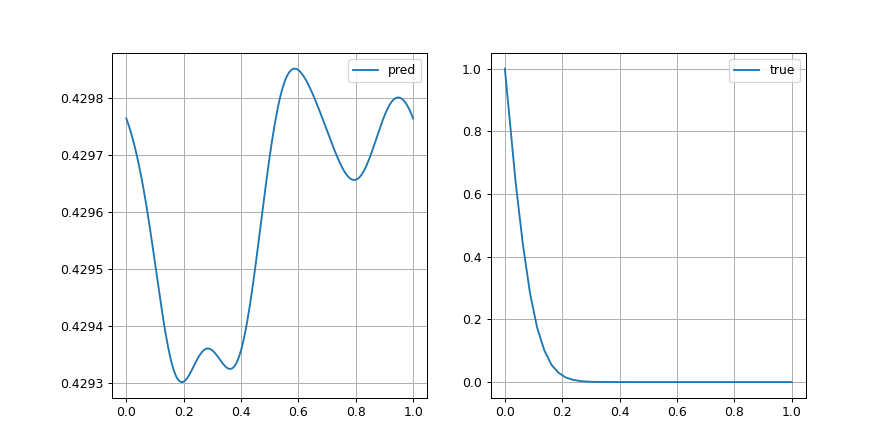

In [13]:
from scipy.io import loadmat
data = loadmat("epsilon_1e-16.mat")
x_true_, u_true = data["x"], data["u"]
x_true = np.zeros_like(u_true)
x_true[0] = 0; x_true[-1] = 1
x_true[1:-1] = x_true_

f, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(x_test, r_hat_preds[-1], label = "pred")
ax[1].plot(x_true, u_true, label = "true")
for i in range(2):
	ax[i].legend()
	ax[i].grid()
plt.show()